# Metody oparte o sąsiedztwo

## Wstęp

Laboratorium składa się z 2 części:
1. kNN w uczeniu nadzorowanym
2. Wyszukiwanie

W pierwszej części użyjemy standardowych bibliotek oraz dodatkowo `pynndescent`, implementującego algorytm NN-Descent do approximate nearest neighbors (ANN).

W drugiej części natomiast do wektoryzacji obiektów użyjemy stosu do uczenia głębokiego opartego o PyTorcha i Sentence Transformers - biblioteki implementującej transformery do uczenia nienadzorowanego i wyszukiwania.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Zbiór danych - klasyfikacja danych numerycznych

Wykorzystamy zbiór danych [Codon usage](https://archive.ics.uci.edu/ml/datasets/Codon+usage) z dziedziny bioinformatyki. Został on zaprezentowany w artykule:

Hallee, Logan, and Bohdan B. Khomtchouk. *"Machine learning classifiers predict key genomic and evolutionary traits across the kingdoms of life."* Scientific Reports 13.1 (2023): 2088. [link](https://www.nature.com/articles/s41598-023-28965-7)

Autorzy wykonywali na nim wiele analiz, ale nas interesuje podstawowa - przewidywanie, z jakiego królestwa (kingdom) pochodzi komórka, na podstawie rozkładu kodonów w jej sekwencjonowanym RNA. Analiza DNA oraz RNA jest podstawowym zadaniem bioinformatyki. Kodony (codons) to trójki nukleotydów, np. UGC, i większość zapisuje pewien aminokwas (z wyjątkiem trzech kodonów stopu), który jest wykorzystywany w syntezie białek.

Problem jest taki, że w praktyce trzeba sekwencjonować DNA/RNA z wielu komórek, więc trzeba je namnożyć w laboratorium. Niestety nie da się uzyskać idealnej czystości, i zawsze jest szansa, że próbka zostanie zanieczyszczona, np. bakteriami. Wtedy oprócz interesujących nas komórek (np. zwierzęcych) otrzymamy inne, których trzeba się pozbyć przed dalszą analizą. Tutaj właśnie wchodzi ML - dokonamy klasyfikacji, z jakiego królestwa (a właściwie domeny) pochodzi kod RNA, żeby pomóc w takich sytuacjach.

Dla uproszczenia, autorzy, zamiast klasyfikować królestwo, klasyfikują [domenę](https://pl.wikipedia.org/wiki/Domena_(biologia)) organizmu. Są to jednostki o poziom wyżej w systematyce taksonomicznej. Do tego dokładamy wirusy i bakteriofagi. Mamy zatem klasy:
1. Archaea ([archeony](https://pl.wikipedia.org/wiki/Archeony)) - drobne jednokomórkowce, źródło ważnych [enzymów stosowanych w biologii molekularnej](https://en.wikipedia.org/wiki/Archaea#Significance_in_technology_and_industry)
2. Bacteria ([bakterie](https://pl.wikipedia.org/wiki/Bakterie))
3. Eukariota ([eukarionty](https://pl.wikipedia.org/wiki/Eukarionty)) - między innymi ludzie
4. Viruses ([wirusy](https://pl.wikipedia.org/wiki/Wirusy)) - nie są organizmami żywymi, więc nie są częścią typowej taksonomii, ale są ważne w badaniach mikrobiologicznych
5. Bacteriophages ([bakteriofagi](https://pl.wikipedia.org/wiki/Bakteriofag)) - rodzaj wirusów atakujących tylko bakterie, używane m.in. [w badaniach nad mikrobiomem jelitowym](https://kids.frontiersin.org/articles/10.3389/frym.2019.00146)

Szczegółowy opis zbioru znajduje się [na stronie UCI](https://archive.ics.uci.edu/ml/datasets/Codon+usage). W skrócie:
1. `Kingdom` - królestwo, z którego pochodzi komórka. Podział jest tutaj dość szczegółowy, ale organizmy te można pogrupować w praktyce na bakterie (bacteria), wirusy (viruses) i eukarionty (eukariota).
2. `DNAtype` - używana w innych analizach w artykule.
3. `SpeciesID` - numer gatunku.
4. `Ncodons` - liczba kodonów zmierzona dla danej komórki.
5. `SpeciesName` - nazwa gatunku.

Dalsze kolumny to znormalizowany ułamek kodonów poszczególnych typów w RNA danej komórki. W związku z tym, że dane są już znormalizowane, nie ma potrzeby ich skalowania.

In [4]:
df = pd.read_csv("codon_usage.csv")
df

/tmp/ipykernel_4739/2756931748.py:1: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("codon_usage.csv")


,Kingdom,DNAtype,SpeciesID,Ncodons,SpeciesName,UUU,UUC,UUA,UUG,CUU,...,CGG,AGA,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA
0,vrl,0,100217,1995,Epizootic haematopoietic necrosis virus,0.01654,0.01203,0.00050,0.00351,0.01203,...,0.00451,0.01303,0.03559,0.01003,0.04612,0.01203,0.04361,0.00251,0.00050,0.00000
1,vrl,0,100220,1474,Bohle iridovirus,0.02714,0.01357,0.00068,0.00678,0.00407,...,0.00136,0.01696,0.03596,0.01221,0.04545,0.01560,0.04410,0.00271,0.00068,0.00000
2,vrl,0,100755,4862,Sweet potato leaf curl virus,0.01974,0.0218,0.01357,0.01543,0.00782,...,0.00596,0.01974,0.02489,0.03126,0.02036,0.02242,0.02468,0.00391,0.00000,0.00144
3,vrl,0,100880,1915,Northern cereal mosaic virus,0.01775,0.02245,0.01619,0.00992,0.01567,...,0.00366,0.01410,0.01671,0.03760,0.01932,0.03029,0.03446,0.00261,0.00157,0.00000
4,vrl,0,100887,22831,Soil-borne cereal mosaic virus,0.02816,0.01371,0.00767,0.03679,0.01380,...,0.00604,0.01494,0.01734,0.04148,0.02483,0.03359,0.03679,0.00000,0.00044,0.00131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13023,pri,0,9601,1097,Pongo pygmaeus abelii,0.02552,0.03555,0.00547,0.01367,0.01276,...,0.00820,0.01367,0.01094,0.01367,0.02279,0.02005,0.04102,0.00091,0.00091,0.00638
13024,pri,1,9601,2067,mitochondrion Pongo pygmaeus abelii,0.01258,0.03193,0.01984,0.00629,0.01451,...,0.00145,0.00000,0.00048,0.00194,0.01306,0.01838,0.00677,0.00242,0.00097,0.01887
13025,pri,1,9602,1686,mitochondrion Pongo pygmaeus pygmaeus,0.01423,0.03321,0.01661,0.00356,0.01127,...,0.00000,0.00000,0.00000,0.00178,0.01661,0.02788,0.00297,0.00356,0.00119,0.02017
13026,pri,0,9606,40662582,Homo sapiens,0.01757,0.02028,0.00767,0.01293,0.01319,...,0.01142,0.01217,0.01196,0.02178,0.02510,0.02896,0.03959,0.00099,0.00079,0.00156


Mamy warning co do typu - niedobrze. Sprawdźmy typy:

In [5]:
df.dtypes.head(20)

Kingdom         object
DNAtype          int64
SpeciesID        int64
Ncodons          int64
SpeciesName     object
UUU             object
UUC             object
UUA            float64
UUG            float64
CUU            float64
CUC            float64
CUA            float64
CUG            float64
AUU            float64
AUC            float64
AUA            float64
AUG            float64
GUU            float64
GUC            float64
GUA            float64
dtype: object

Kolumny `UUU` i `UUC` powinny być floatami - niedobrze. Na szczęście to tylko literówka w jednym wierszu, co można sprawdzić w danych. Usuniemy ją po prostu.

In [6]:
df = df[pd.to_numeric(df["UUU"], errors="coerce").notnull()].copy()

df = df.copy()  # to avoid irritating SettingWithCopyWarning

df["UUU"] = df.loc[:, "UUU"].astype(float)
df["UUC"] = df.loc[:, "UUC"].astype(float)

df.dtypes.head(20)

Kingdom         object
DNAtype          int64
SpeciesID        int64
Ncodons          int64
SpeciesName     object
UUU            float64
UUC            float64
UUA            float64
UUG            float64
CUU            float64
CUC            float64
CUA            float64
CUG            float64
AUU            float64
AUC            float64
AUA            float64
AUG            float64
GUU            float64
GUC            float64
GUA            float64
dtype: object

**Zadanie 1 (1.5 punktu)**

1. Usuń wiersze mające mniej niż 1000 kodonów
2. Usuń wiersze dla plazmidów (wartość `plm` dla królestwa)
3. Usuń kolumny bezużyteczne dla ML: `DNAtype`, `SpeciesID`, `Ncodons`, `SpeciesName`
4. Zakoduj klasy (kolumna `Kingdom`):
  - 0 - archaea, `arc`
  - 1 - bacteria, `bct`
  - 2 - eukaryota, `pln`, `inv`, `vrt`, `mam`, `rod`, `pri`
  - 3 - bacteriophages (phages), `phg`
  - 4 - viruses (viral cells), `vrl`
5. Wyodrębnij klasy jako osobną zmienną `y`. Pamiętaj o usunięciu tej kolumny z oryginalnego DataFrame'a.
6. Narysuj wykres rozkładu klas:
   - wykres słupkowy (bar plot)
   - na osi X mają być nazwy klas pod słupkami, wypisane poziomo
   - wartości na osi Y mają być w procentach (znormalizowane 0-100)
   - pamiętaj o tytule oraz opisaniu osi

In [7]:
mapping = {
    'arc' : 0,
    'bct' : 1,
    'pln' : 2, 'inv' : 2, 'vrt' : 2, 'mam' : 2, 'rod' : 2, 'pri' : 2,
    'phg' : 3,
    'vrl' : 4
}

df = df[df["Ncodons"] >= 1000]
df = df[df["Kingdom"] != "plm"]
df = df.drop(columns=["DNAtype", "SpeciesID", "Ncodons", "SpeciesName"])

df["Kingdom"] = df["Kingdom"].map(mapping)

y = df["Kingdom"]
df = df.drop(columns=["Kingdom"])

Text(0.5, 1.0, 'rozkład klas')

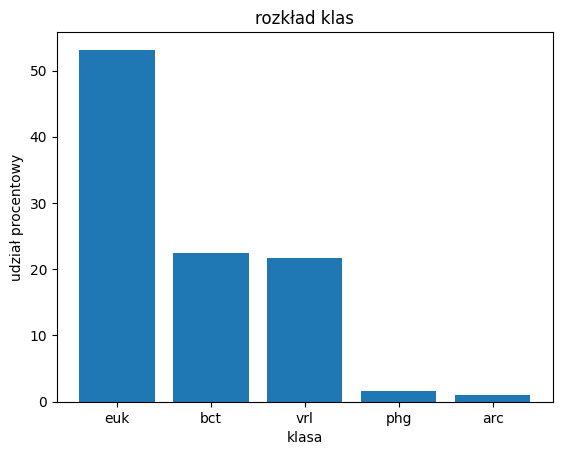

In [8]:
import matplotlib.pyplot as plt

re_mapping = {
    0 : 'arc',
    1 : 'bct',
    2 : 'euk',
    3 : 'phg',
    4 : 'vrl'
}

class_counts = y.value_counts(normalize=True) * 100
plt.bar(class_counts.index.map(re_mapping), class_counts.values)
plt.xlabel("klasa")
plt.ylabel("udział procentowy")
plt.title("rozkład klas")


Jak widać, mamy nie tylko klasyfikację wieloklasową, ale na dodatek klasyfikację niezbalansowaną. W takim przypadku trzeba użyć odpowiednich metryk. Wzorując się na artykule, użyjemy **macro-averaged F1-score**. Jest to proste rozwinięcie F1-score na wiele klas.

Dla przypomnienia, w klasyfikacji binarnej, F1-score to średnia harmoniczna precyzji (precision) i czułości (recall):

$$
F1 = \frac{2}{recall^{-1} + precision^{-1}} = 2 * \frac{precision * recall}{precision + recall} = \frac{2 * TP}{2 * TP + FP + FN}
$$

Macro-averaging oznacza, że najpierw obliczamy F1-score dla każdej klasy, a później bierzemy ich średnią. Żeby taka średnia była wysoka, to musimy mieć wysoki wynik na wszystkich 5 klasach, w tym 2 mniejszościowych, więc uwzględnimy niezbalansowanie klas.

## Klasyfikator kNN

Wytrenujemy teraz podstawowy algorytm k najbliższych sąsiadów, korzystając z samych wartości domyślnych ze Scikit-learn: 5 sąsiadów, metryka euklidesowa, brak ważenia.

Zgodnie z artykułem, wykorzystamy zwykłą metodę holdout do testowania, dzieląc zbiór na treningowy i testowy w proporcjach 80%-20%. Zrobimy to ze **stratyfikacją (stratification)**, czyli tak, żeby rozkład klas był taki sam w obu podzbiorach.

In [9]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    df, y, test_size=0.2, random_state=0, stratify=y
)

In [10]:
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier


clf = KNeighborsClassifier(n_jobs=-1)
clf.fit(X_train, y_train)

y_pred_score_train = clf.predict(X_train)
y_pred_score_test = clf.predict(X_test)

f1_train = f1_score(y_train, y_pred_score_train, average="macro")
f1_test = f1_score(y_test, y_pred_score_test, average="macro")

print(f"F1 train: {100 * f1_train:.2f}%")
print(f"F1 test: {100 * f1_test:.2f}%")

F1 train: 92.51%
F1 test: 91.35%


Wyniki są całkiem niezłe, ale jest jeszcze miejsce na poprawę. Być może zmiana liczby sąsiadów albo metryki, albo też dodanie ważenia sąsiadów da nam jeszcze kilka procent.

W przypadku wielu klas samo agregowane F1 nie zawsze mówi jednak wszystko. Zawsze warto sprawdzić **macierz pomyłek (confusion matrix)**. Co ważne, można ją rysować albo z surową liczbą przykładów, albo znormalizować, żeby dostać wyniki w ułamku (zakres wartości 0-1). Pierwsza możliwość jest przydatna, kiedy mamy niezbalansowane klasy i patrzymy na ogólną jakość klasyfikatora. Znormalizowane wykresy są z kolei przydatne, kiedy przyglądamy się klasom z osobna.

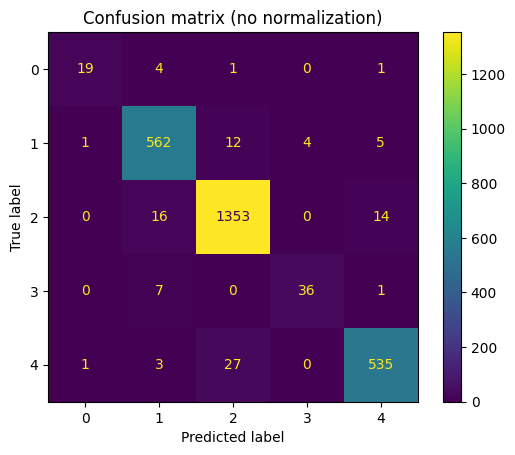

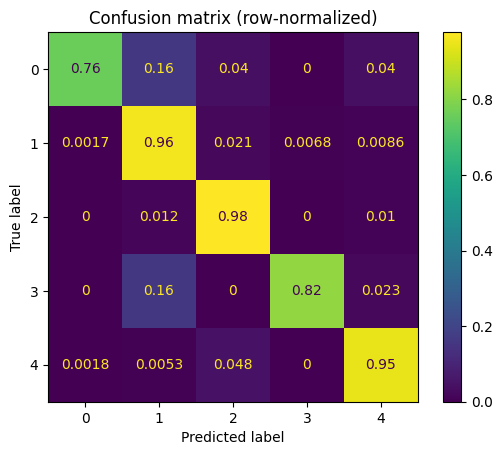

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)
plt.title("Confusion matrix (no normalization)")
plt.show()


ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, normalize="true")
plt.title("Confusion matrix (row-normalized)")
plt.show()

Wyniki są całkiem niezłe, w końcu mamy wysokie F1. Widać jednak, że dość często mylimy klasę 0 (archeony) oraz klasę 3 (bakteriofagi) z klasą 1 (bakterie) - jest to problematyczne, ale zrozumiałe, bo tych klas jest najmniej.

Po tuningu powinniśmy otrzymać lepsze wyniki. Na dobry początek sprawdzimy różną liczbę sąsiadów. Trzeba zwrócić uwagę, że jeżeli nasza metryka ma jakieś argumenty, to trzeba użyć funkcji `make_scorer` i przekazać wynik do `GridSearchCV`.

Zwróć też uwagę, że skoro przekazujemy `n_jobs=-1` do klasyfikatora, to grid search dostaje `n_jobs=None`, żeby mieć tyle procesów, co rdzeni procesora. Przy okazji zmierzymy też czas tuningu.

In [12]:
from time import time

from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV


clf = KNeighborsClassifier(n_jobs=-1)

param_grid = {
    "n_neighbors": list(range(1, 51)),
}

multiclass_f1 = make_scorer(
    f1_score,
    average="macro",
    greater_is_better=True,
)

cv = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring=multiclass_f1,
    cv=5,
)

time_start = time()
cv.fit(X_train, y_train)
time_end = time()

print(f"Optimal number of neighbors: {cv.best_params_['n_neighbors']}")
print(f"Tuning time: {time_end - time_start:.2f} s")

y_pred_score_train = cv.predict(X_train)
y_pred_score_test = cv.predict(X_test)

f1_train = f1_score(y_train, y_pred_score_train, average="macro")
f1_test = f1_score(y_test, y_pred_score_test, average="macro")

print(f"F1 train: {100 * f1_train:.2f}%")
print(f"F1 test: {100 * f1_test:.2f}%")

Optimal number of neighbors: 1
Tuning time: 21.64 s
F1 train: 100.00%
F1 test: 89.16%


Co ciekawe, po tuningu nie tylko nie mamy lepszego wyniku, ale wręcz przeuczamy bardziej! Tak się niestety zdarza - tuning opiera się na wyniku na zbiorze walidacyjnym, które nie zawsze są dobrą estymatą. Pewnym sposobem na ominięcie tego jest zmniejszenie zakresu dla hiperparametru. Tutaj wiemy, że:
- im mniejsza liczba sąsiadów, tym większa wariancja (mocniejszy overfitting) i na odwrót
- domyślna liczba sąsiadów to 5
- przy 4 przeuczamy mocniej

Można więc po prostu sprawdzać zakres od 5 wzwyż. Do tego czeka nas jeszcze tuning metryki i ważenia sąsiadów.

**Zadanie 2 (1.5 punktu)**

1. Dokonaj tuningu: liczby sąsiadów (zakres [5, 25]), metryki (euklidesowa, Manhattan, cosinusowa) oraz ważenia sąsiadów (brak vs ważenie odległością). Jakie są optymalne wartości hiperparametrów?
2. Zmierz czas. Czy twoim zdaniem to długo, dla zbioru, który ma ok. 10k próbek uczących?
3. Narysuj macierz pomyłek dla zbioru testowgeo. Czy wygląda sensownie, szczególnie dla klas mniejszościowych? Czy udało się uzyskać wynik lepszy od bazowego?

In [16]:
param_grid = {
    "n_neighbors" : list(range(5,25)),
    "metric" : ["euclidean", "manhattan", "cosine"],
    "weights" : ["uniform", "distance"]
}

cv = GridSearchCV(
    param_grid=param_grid,
    estimator=clf,
    scoring=multiclass_f1,
    cv=5
)

start_t = time()
cv.fit(X_train, y_train)
end_t = time()

print(f"optymalna liczba somsiadów: {cv.best_params_['n_neighbors']}")
print(f"czas tuningu: {end_t-start_t}")

y_pred_train = cv.predict(X_train)
y_pred_test = cv.predict(X_test)

f1_train = f1_score(y_train, y_pred_train, average="macro")
f1_test = f1_score(y_test, y_pred_test, average='macro')

print(f"f1 test: {f1_test * 100:.2f}")
print(f"f1 train: {f1_train * 100:.2f}")

optymalna liczba somsiadów: 6
czas tuningu: 126.57169723510742
f1 test: 91.53
f1 train: 100.00


In [17]:
cv.best_params_

{'metric': 'cosine', 'n_neighbors': 6, 'weights': 'distance'}

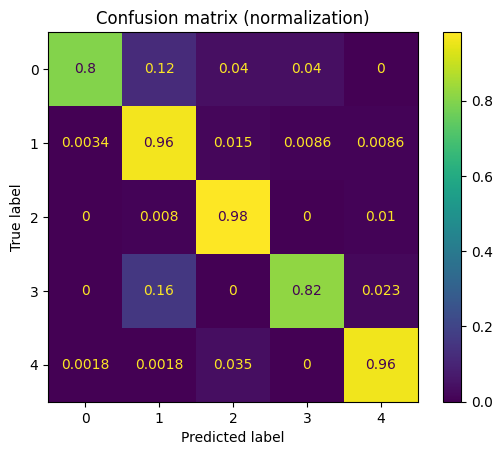

In [18]:
ConfusionMatrixDisplay.from_estimator(cv, X_test, y_test, normalize="true")
plt.title("Confusion matrix (normalization)")
plt.show()

Trochę dalej overfituje ale ma lepsze wyniki i czas nie był zły

## Approximate Nearest Neighbors (ANN)

Postaramy się teraz przyspieszyć nasz klasyfikator, w zamian za odrobinę dokładności, za pomocą algorytmu przybliżonych najbliższych sąsiadów, a konkretnie [NN-Descent](https://pynndescent.readthedocs.io/en/latest/index.html). Ten został wybrany głównie ze względu na łatwą w użyciu implementację.

Twórcy Scikit-learn'a zdawali sobie sprawę, że algorytmy znajdowania najbliższych sąsiadów to aktywne pole rozwoju, dlatego stworzyli klasę (i interfejs) `KNeighborsTransformer`, pozwalającą integrować zewnętrzne rozwiązania. Działa ona zarówno do klasyfikacji / regresji kNN, jak i do innych algorytmów opartych o sąsiedztwo, które budują graf najbliższych sąsiadów. W przypadku jego użycia trzeba podać `metric="precomputed"`, bo obliczaniem odległości zajmuje się osobny algorytm.

Implementacja PyNNDescent korzysta właśnie z tego rozwiązania, co gwarantuje łatwość użycia - klasa `PyNNDescentTransformer` dziedziczy po `KNeighborsTransformer`. Zobaczmy, jak to działa. Wykorzystamy funkcję `make_pipeline()`, która buduje obiekt `Pipeline`, ale nie wymaga podawania nazw kolejnych elementów.

**Uwaga:** PyNNDescent dla wydajności korzysta z Numby, czyli kompilatora JIT (Just-In-Time). Dzięki temu działa to bardzo szybko, ale pierwszy import i wykonanie zajmuje sporo czasu. Wykonaj kod 2 razy - za drugim razem będzie o wiele szybciej.

In [19]:
from time import time


def benchmark_knn_and_ann(
    sklearn_knn,
    pynndescent_ann,
    X_train,
    X_test,
    y_train,
    y_test,
) -> None:
    # training
    start_time = time()
    sklearn_knn.fit(X_train, y_train)
    end_time = time()

    sklearn_knn_fit_time = end_time - start_time

    start_time = time()
    pynndescent_ann.fit(X_train, y_train)
    end_time = time()

    pynndescent_ann_fit_time = end_time - start_time

    # prediction

    start_time = time()
    y_pred_sklearn = sklearn_knn.predict(X_test)
    end_time = time()

    sklearn_knn_predict_time = end_time - start_time

    start_time = time()
    y_pred_pynndescent = pynndescent_ann.predict(X_test)
    end_time = time()

    pynndescent_ann_predict_time = end_time - start_time

    f1_knn = f1_score(y_test, y_pred_sklearn, average="macro")
    f1_ann = f1_score(y_test, y_pred_pynndescent, average="macro")

    print(f"Scikit-learn training time: {sklearn_knn_fit_time:.2f}")
    print(f"PyNNDescent training time: {pynndescent_ann_fit_time:.2f}")
    print()
    print(f"Scikit-learn prediction time: {sklearn_knn_predict_time:.2f}")
    print(f"PyNNDescent prediction time: {pynndescent_ann_predict_time:.2f}")
    print()
    print(f"Scikit-learn F1: {100 * f1_knn:.2f}%")
    print(f"PyNNDescent F1: {100 * f1_ann:.2f}%")

In [20]:
from pynndescent import PyNNDescentTransformer
from sklearn.pipeline import make_pipeline


sklearn_knn = KNeighborsClassifier(metric="euclidean")

pynndescent_ann = make_pipeline(
    PyNNDescentTransformer(metric="euclidean", random_state=0),
    KNeighborsClassifier(metric="precomputed"),
)

benchmark_knn_and_ann(sklearn_knn, pynndescent_ann, X_train, X_test, y_train, y_test)

/home/hubert/podstawy-uczenia-maszynowego-24-25/.venv/lib/python3.11/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


Scikit-learn training time: 0.00
PyNNDescent training time: 18.43

Scikit-learn prediction time: 0.09
PyNNDescent prediction time: 0.09

Scikit-learn F1: 91.35%
PyNNDescent F1: 91.25%


Czas treningu jest dłuższy - to oczekiwany wynik. Natomiast czas predykcji jest podobny - wynika to z tego, że dla metryki euklidesowej k-d tree jest bardzo wydajne. Wynik jest bardzo podobny, więc mamy dobre przybliżenie.

Sprawdźmy metrykę Manhattan, dla której typowo k-d tree radzi sobie nieco gorzej.

In [21]:
sklearn_knn = KNeighborsClassifier(metric="manhattan")

pynndescent_ann = make_pipeline(
    PyNNDescentTransformer(metric="manhattan", random_state=0),
    KNeighborsClassifier(metric="precomputed"),
)

benchmark_knn_and_ann(sklearn_knn, pynndescent_ann, X_train, X_test, y_train, y_test)

Scikit-learn training time: 0.00
PyNNDescent training time: 6.80

Scikit-learn prediction time: 0.40
PyNNDescent prediction time: 0.11

Scikit-learn F1: 91.39%
PyNNDescent F1: 91.39%


Tutaj predykcja ANN jest już wyraźnie szybsza - co prawda dane są niezbyt duże, więc nie ma to aż takiego znaczenia, ale widać potencjał skalowalności. Dodatkowo wynik jest taki sam.

## Zbiór danych - klasyfikacja danych chemicznych

Teraz zajmiemy się klasyfikacją zbioru posiadającego same zmienne binarne, do których trzeba użyć odpowiednich metryk. Konkretnie, będzie to zbiór [HIV z benchmarku MoleculeNet](https://moleculenet.org/datasets-1), w którym na podstawie reprezentacji chemicznej molekuły trzeba przewidywać, czy jest ona inhibitorem wirusa HIV. [Inhibitory](https://en.wikipedia.org/wiki/Reaction_inhibitor) to substancje przeciwne do katalizatorów - spowalniają lub uniemożliwiają jakieś zjawisko, w naszym wypadku infekcję wirusa HIV. Przewidywanie własności molekuł to kluczowe zadanie w nowoczesnym projektowaniu leków i bardzo ważne zastosowanie ML w farmacji i chemii molekularnej.

Zbiór jest już podzielony na treningowy, walidacyjny i testowy w ramach projektu [Open Graph Benchmark](https://ogb.stanford.edu/docs/graphprop/). Dane te można traktować jak klasyfikację grafów molekularnych, np. z pomocą grafowych sieci neuronowych. Jednak podejściem klasycznym i dającym często lepsze wyniki są **fingerprinty molekularne (molecular fingerprints)**. Są to deterministyczne algorytmy ekstrakcji cech z grafu, zamieniające go na wektor. Jest ich dużo, ale najpopularniejszy to [ECFP (Extended Connectivity FingerPrint)](https://docs.chemaxon.com/display/docs/extended-connectivity-fingerprint-ecfp.md), wykorzystujący informację o subgrafach o małym promieniu (typowo 4). Domyślnie skutkuje to cechami binarnymi, czy subgraf wystąpił, czy nie w danej molekule.

Molekuły są typowo przechowywane w formacie [SMILES strings](https://en.wikipedia.org/wiki/Simplified_Molecular_Input_Line_Entry_System). Graf molekularny można odczytać z tego formatu, a potem przekazać taki zbiór do fingerprintu. Wtedy zamieniamy problem na zwykłą klasyfikację tabelaryczną. Scikit-fingerprints zrobi to automatycznie, jeżeli SMILES strings zostaną przekazane do fingerprintu.

Jako że zbiór jest binarny, to nie ma potrzeby żadnego skalowania zmiennych. W przypadku zbioru HIV typową metryką jest Area Under Receiver Operating Characteristic (AUROC / ROC AUC).

**Zadanie 3 (1 punkt)**

1. Załaduj zbiór HIV z pomocą funkcji [load_hiv()](https://scikit-fingerprints.github.io/scikit-fingerprints/modules/datasets/generated/skfp.datasets.moleculenet.load_hiv.html#skfp.datasets.moleculenet.load_hiv). Wypisz kilka pierwszych SMILESów.
2. Załaduj indeksy treningowe, walidacyjne i testowe z benchmarku OGB z pomocą funkcji [load_ogb_splits()](https://scikit-fingerprints.github.io/scikit-fingerprints/modules/datasets/generated/skfp.datasets.moleculenet.load_ogb_splits.html).
3. Podziel zbiór (SMILES oraz klasy `y`) na treningowe, walidacyjne i treningowe.
4. Narysuj wykres częstości klas w zbiorze treningowym. Jak sądzisz, czemu akurat AUROC zostało tutaj wybrane jako metryka?
5. Oblicz fingerprinty ECFP z użyciem [ECFPFingerprint](https://scikit-fingerprints.github.io/scikit-fingerprints/modules/generated/skfp.fingerprints.ECFPFingerprint.html#skfp.fingerprints.ECFPFingerprint) dla wszystkich 3 podzbiorów.

In [37]:
from skfp.datasets.moleculenet import load_hiv, load_ogb_splits
from skfp.fingerprints import ECFPFingerprint

data = load_hiv(as_frame=True)
smiles = data['SMILES']
y = data['label']
smiles.head()


/home/hubert/podstawy-uczenia-maszynowego-24-25/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


0    CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...
1    C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...
2                     CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21
3      Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1
4                               O=S(=O)(O)CCS(=O)(=O)O
Name: SMILES, dtype: object

In [38]:
splits = load_ogb_splits("HIV", as_dict=True)
train_idx, val_idx, test_idx = splits["train"], splits["valid"], splits["test"]

smiles_train, y_train = smiles.iloc[train_idx], y.iloc[train_idx]
smiles_val, y_val = smiles.iloc[val_idx], y.iloc[val_idx]
smiles_test, y_test = smiles.iloc[test_idx], y.iloc[test_idx]

/home/hubert/podstawy-uczenia-maszynowego-24-25/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


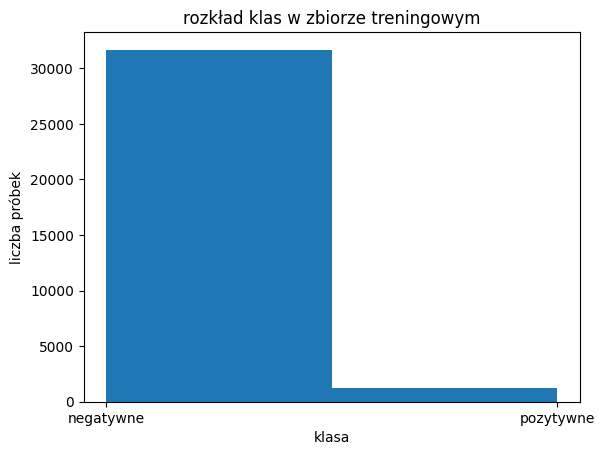

In [40]:
plt.hist(y_train, bins=2)
plt.xticks([0, 1], ['negatywne', 'pozytywne'])
plt.xlabel("klasa")
plt.ylabel("liczba próbek")
plt.title("rozkład klas w zbiorze treningowym")
plt.show()

In [ ]:
fp = ECFPFingerprint()
X_train = fp.transform(smiles_train.tolist())
X_val = fp.transform(smiles_val.tolist())
X_test = fp.transform(smiles_test.tolist())

[19:17:33] WARNING: not removing hydrogen atom without neighbors
[19:17:33] WARNING: not removing hydrogen atom without neighbors


**Zadanie 4 (1.5 punktu)**

1. Wytrenuj klasyfikator kNN z domyślnymi hiperparametrami, używając metryki Jaccarda (Tanimoto). Zmierz AUROC na zbiorze testowym. Pamiętaj, żeby przekazać odpowiednie wartości do metryki (patrz [przykład w dokumentacji](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)).
2. Zmierz czas treningu oraz predykcji. Czy podczas treningu została zbudowana jakakolwiek struktura danych?
3. Dokonaj tuningu liczby sąsiadów z zakresu [1, 5, 10]. Wykorzystaj tutaj istniejący zbiór walidacyjny z pomocą `PredefinedSplit`. Może się przydać [ta odpowiedź na StackOverflow](https://stackoverflow.com/a/70155766/9472066). Do tuningu wykorzystaj metrykę AUROC (argument `scoring`).
4. Porównaj wyniki algorytmu po tuningu z wynikami z artykułu ["Molecular Topological Profile (MOLTOP) -- Simple and Strong Baseline for Molecular Graph Classification" J. Adamczyk, W. Czech](https://arxiv.org/abs/2407.12136).

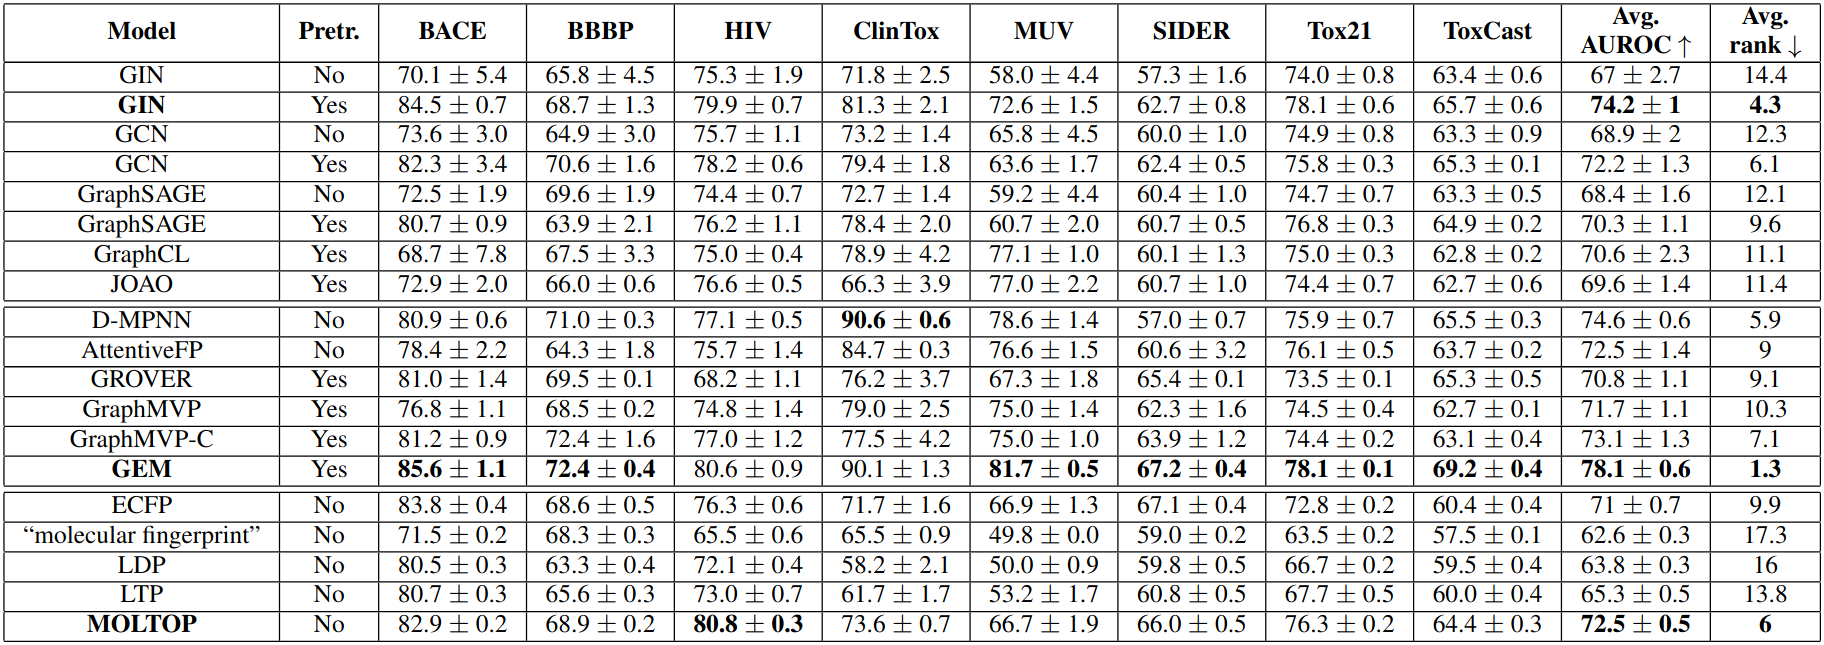

In [43]:
from sklearn.neighbors import KNeighborsClassifier
from time import time
mol_knn = KNeighborsClassifier(metric='jaccard')

t1 = time()
mol_knn.fit(X_train, y_train)
t2 = time()
y_predict = mol_knn.predict(X_test)
t3 = time()
print("kNN jaccard training time", t2 - t1)
print("kNN jaccard predict time", t3 - t2)


/home/hubert/podstawy-uczenia-maszynowego-24-25/.venv/lib/python3.11/site-packages/sklearn/metrics/pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/home/hubert/podstawy-uczenia-maszynowego-24-25/.venv/lib/python3.11/site-packages/sklearn/metrics/pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


kNN jaccard training time 0.003013134002685547
kNN jaccard predict time 453.14690017700195


In [44]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_test, y_predict))

0.5901736225110565


In [45]:
from sklearn.model_selection import PredefinedSplit, GridSearchCV
split_index = [-1]*len(X_train) + [0]*len(X_val)
X = np.concatenate((X_train, X_val), axis=0)
y = np.concatenate((y_train, y_val), axis=0)
pds = PredefinedSplit(test_fold = split_index)

param_grid = {
    "n_neighbors" : [1,5,10],
    "metric" : ['jaccard']
}

mol_knn = KNeighborsClassifier()
clf = GridSearchCV(estimator = mol_knn,
                   cv=pds,
                   param_grid=param_grid,
                   scoring=roc_auc_score)

clf.fit(X, y)

/home/hubert/podstawy-uczenia-maszynowego-24-25/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/hubert/podstawy-uczenia-maszynowego-24-25/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/hubert/podstawy-uczenia-maszynowego-24-25/.venv/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 194, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/hubert/.local/share/uv/python/cpython-3.11.11-linux-x86_64-gnu/lib/python3.11/inspect.py", line 3195, in bind
    return self._bind(args, kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^
  File "

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=KNeighborsClassifier(),
             param_grid={'metric': ['jaccard'], 'n_neighbors': [1, 5, 10]},
             scoring=<function roc_auc_score at 0x7996369889a0>)

In [46]:
y_predict = clf.predict_proba(X_test)[:,1]

/home/hubert/podstawy-uczenia-maszynowego-24-25/.venv/lib/python3.11/site-packages/sklearn/metrics/pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/home/hubert/podstawy-uczenia-maszynowego-24-25/.venv/lib/python3.11/site-packages/sklearn/metrics/pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


In [47]:
roc_auc_score(y_test, y_predict)

np.float64(0.6112767724367021)

// skomentuj tutaj

**Zadanie 5 (1.5 punktu)**

1. Stwórz pipeline do klasyfikacji ANN z użyciem PyNNDescent. Wykorzystaj metrykę Jaccarda (Tanimoto) i znalezioną wcześniej optymalną liczbę sąsiadów.
2. Wytrenuj zwykłe kNN oraz ANN oraz dokonaj predykcji. Zmierz czas oraz dokładność obu metod. Czy twoim zdaniem warto dokonać w tym wypadku takiej aproksymacji?

In [48]:
from pynndescent import PyNNDescentTransformer
from sklearn.pipeline import make_pipeline

sklearn_knn = KNeighborsClassifier(metric='jaccard')

pynndescent_ann = make_pipeline(
    PyNNDescentTransformer(metric='jaccard', random_state=0),
    KNeighborsClassifier(metric="precomputed"),
)

benchmark_knn_and_ann(sklearn_knn, pynndescent_ann, X_train, X_test, y_train, y_test)


/home/hubert/podstawy-uczenia-maszynowego-24-25/.venv/lib/python3.11/site-packages/sklearn/metrics/pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/home/hubert/podstawy-uczenia-maszynowego-24-25/.venv/lib/python3.11/site-packages/sklearn/metrics/pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


Scikit-learn training time: 0.00
PyNNDescent training time: 16.68

Scikit-learn prediction time: 451.58
PyNNDescent prediction time: 2.10

Scikit-learn F1: 63.27%
PyNNDescent F1: 63.27%


## Wyszukiwanie z pomocą najbliższych sąsiadów

Naszym ostatnim zastosowaniem metod opartych o sąsiedztwo będzie wyszukiwanie przedmiotów. Konkretnie stworzymy wyszukiwarkę obrazów na podstawie wpisanego hasła.

Jest to zadanie **multimodalne (multimodal)**, bo operujemy na dwóch różnych modalnościach: obrazie i tekście. Takie wyszukiwarki działają następująco:
1. W fazie treningu przedmioty (obrazy) są wektoryzowane siecią neuronową i przechowywane w indeksie.
2. Użytkownik wpisuje tekst, który jest wektoryzowany za pomocą tej samej sieci neuronowej, dlatego musi być ona multimodalna.
3. Wyszukujemy najbliższych sąsiadów (obrazy-wektory) dla tekstu-wektora.

Najbardziej znanym modelem multimodalnym jest [CLIP](https://openai.com/research/clip), stworzony przez OpenAI. Jego architektura i wagi są dostępne publicznie, w przeciwieństwie do nowych rozwiązań tej firmy. Jest to model zasadniczo niewymagający fine-tuningu, działa bardzo dobrze w podstawowej formie dla wielu zadań. Został też wykorzystany jako element modelu [DALL-E 2](https://openai.com/product/dall-e-2).

Nie musisz szczegółowo wiedzieć, jak działa ten model, ale pewne podstawy są bardzo ciekawe i przydatne. Wysokopoziomowo architekturę dobrze opisuje [ten artykuł](https://towardsdatascience.com/clip-the-most-influential-ai-model-from-openai-and-how-to-use-it-f8ee408958b1). Dla zainteresowanych [cały artykuł](https://cdn.openai.com/papers/Learning_Transferable_Visual_Models_From_Natural_Language.pdf), znacznie bardziej szczegółowy. CLIP składa się z dwóch enkoderów: dla tekstu i dla obrazu. Są to zwykłe pre-trenowane sieci, a konkretnie:
1. Dla obrazu - [Visual Transformer (ViT)](https://www.v7labs.com/blog/vision-transformer-guide). Jest to architektura, która używa transformerów i atencji do przetwarzania obrazów. Ideą jest, żeby pociąć obraz na sąsiadujące kawałki (patches), i traktować je jak słowa dla atencji.
2. Dla tekstu - [Transformer](https://machinelearningmastery.com/the-transformer-model/), z pewnymi modyfikacjami.

Każda z tych sieci wektoryzuje wejście, dając embedding.

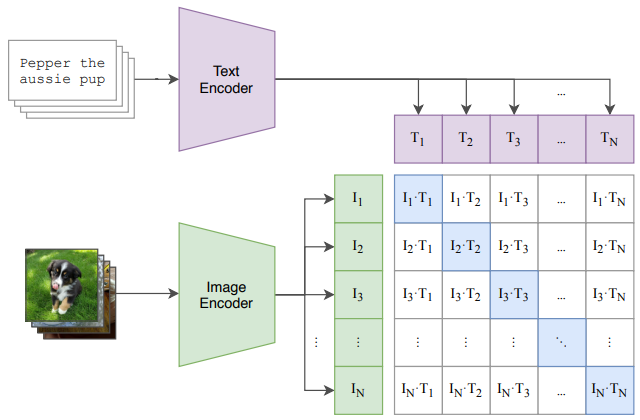

Zbiorem danych była kolekcja 400 milionów par (obraz, tekst), gdzie tekst opisywał zawartość obrazu. Następnie wykonano **constrastive pre-training** - model dostaje batch $N$ par (obraz, tekst) i ma przewidzieć, które z $N \times N$ możliwych kombinacji (obraz, tekst) faktycznie wystąpiły. W tym celu maksymalizuje podobieństwo cosinusowe par, które wystąpiły w batchu, a minimalizuje podobieństwo dla $N^2 - N$ możliwych kombinacji, których nie było w batchu. W tym celu jest używana entropia krzyżowa z pewnymi modyfikacjami.

Widać więc, że model jest nienadzorowany, a zbiór danych był ogromny, więc fine-tuning nie jest nam zasadniczo potrzebny. Można go użyć do klasyfikacji, ale tym nie będziemy się zajmować. Dodatkowo odpowiednią metryką odległości dla najbliższych sąsiadów będzie podobieństwo cosinusowe.

Biblioteka [Sentence-Transformers](https://www.sbert.net/index.html) powstała dla różnych modeli transformerowych do zadań nienadzorowanych, ale dodano do niej także bardzo wygodny interfejs dla modelu CLIP - [przykład użycia](https://www.sbert.net/examples/applications/image-search/README.html). 

Jako zbiór wykorzystamy [Amazon Berkeley Objects (ABO) Dataset](https://amazon-berkeley-objects.s3.amazonaws.com/index.html) - zbiór obrazów produktów Amazona, stworzony we współpracy z University of California, Berkeley. Wykorzystamy [zminiaturyzowany zbiór](https://amazon-berkeley-objects.s3.amazonaws.com/archives/abo-images-small.tar), w którym obrazy mają rozmiar 256x256 pikseli, bo na nasze potrzeby jest zupełnie wystarczający.

**Zadanie 6 (3 punkty)**

*Wyszukiwarka z ANN*

1. Ściągnij [zbiór danych](https://amazon-berkeley-objects.s3.amazonaws.com/archives/abo-images-small.tar). Rozpakuj go obok tego notebooka. W katalogu `images/metadata` znajdziesz plik `images.csv.gz` - zawiera on ścieżki do obrazów.
2. Uzupełnij kod funkcji `vectorize_images`, która oblicza embeddingi obrazów za pomocą modelu CLIP. Przyda ci się [ten tutorial](https://www.sbert.net/examples/applications/image-search/README.html). Ustaw wartość MAX_IMAGES tak, żeby wystarczyło ci RAMu i żeby proces trwał rozsądną ilość czasu (ale co najmniej kilka-kilkanaście minut). `start_idx` oraz `end_idx` to indeksy wierszy, na których w danej chwili operujemy - po prostu przesuwamy się o `BATCH_SIZE` w pętli for.
3. Uzupełnij kod klasy `ImageSearch`:
  - w konstruktorze stwórz indeks za pomocą klasy [NNDescent](https://pynndescent.readthedocs.io/en/latest/api.html#pynndescent.pynndescent_.NNDescent), korzystając z metryki cosinusowej i `random_state=0`, może się też przydać `n_jobs=-1`
  - w metodzie `query` zwektoryzuj zapytanie tekstowe, a następ wyszukaj indeksy najbliższych sąsiadów-obrazów w indeksie (zwróć uwagę na to, co zwraca metoda `.query()` dla `NNDescent`), a następnie zwróć ścieżki do ich obrazów; zwróć uwagę na to, że `.query()` wymaga 2-wymiarowego wejścia, więc w naszym wypadku `(1, 512)`
  - w metodzie `show_images` załaduj i wyświetl obrazy; może się przydać [ten przykład](https://matplotlib.org/stable/gallery/axes_grid1/simple_axesgrid.html)
4. Przetestuj wyszukiwarkę kilkoma hasłami (metoda `.search()`). Prawdopodobnie najlepiej zadziałają hasła odpowiadające typowym produktom sprzedawanym w Amazonie.
5. Jakie widzisz zalety i wady takiego podejścia do wyszukiwania?

**Uwaga:** jeżeli masz mało RAMu lub pracujesz na Google Colab, to warto zrestartować Jupyter Notebooka, zamykając kernel. Zwolni ci to pamięć. Możesz też usunąć macierz z embeddingami (`del embeddings`) kiedy stworzysz indeks w konstruktorze `ImageSearch`.

In [49]:
!wget https://amazon-berkeley-objects.s3.amazonaws.com/archives/abo-images-small.tar

--2025-04-03 19:49:36--  https://amazon-berkeley-objects.s3.amazonaws.com/archives/abo-images-small.tar
Resolving amazon-berkeley-objects.s3.amazonaws.com (amazon-berkeley-objects.s3.amazonaws.com)... 54.231.140.97, 16.182.98.129, 3.5.30.219, ...
Connecting to amazon-berkeley-objects.s3.amazonaws.com (amazon-berkeley-objects.s3.amazonaws.com)|54.231.140.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3253381120 (3.0G) [application/x-tar]
Saving to: ‘abo-images-small.tar’

abo-images-small.ta 100%[===================>]   3.03G  19.6MB/s    in 1h 41m  

2025-04-03 21:30:44 (524 KB/s) - ‘abo-images-small.tar’ saved [3253381120/3253381120]



In [50]:
!tar -xf abo-images-small.tar

In [51]:
# prepare pd.Series with paths to images
image_paths = pd.read_csv("images/metadata/images.csv.gz")

# "height" and "width" are original image size, let's select
# only large ones - they are probably more interesting
mask = (image_paths["height"] >= 1000) & (image_paths["width"] >= 1000)
image_paths = image_paths.loc[mask, :]

# remove columns, leaving only pd.Series with paths
image_paths = image_paths["path"]
image_paths = "images/small/" + image_paths.astype(str)

image_paths

554       images/small/46/4689906d.png
6614      images/small/0c/0cd7596c.jpg
6617      images/small/e6/e602a9af.jpg
6621      images/small/e7/e7cfeb02.jpg
6627      images/small/68/6839db4e.jpg
                      ...             
398207    images/small/6d/6d49d130.jpg
398208    images/small/b1/b163e0ea.jpg
398209    images/small/a1/a116d9d1.jpg
398210    images/small/9c/9c3e1158.jpg
398211    images/small/cf/cf112e38.jpg
Name: path, Length: 342878, dtype: object

In [58]:
from itertools import islice
from PIL import Image
import joblib
import torch
from sentence_transformers import SentenceTransformer
from tqdm.notebook import tqdm


MAX_IMAGES = 50000
BATCH_SIZE = joblib.cpu_count(only_physical_cores=True)


def vectorize_images(image_paths: pd.Series) -> np.ndarray:
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = SentenceTransformer("clip-ViT-B-32", device=device)

    # batch iterator, based on Python itertools example
    def batched(iterable, n: int):
        it = iter(iterable)
        while batch := tuple(islice(it, n)):
            yield batch

    # CLIP embeddings have 512 dimensions
    embeddings = np.empty((MAX_IMAGES, 512))

    # iterate with tqdm, it will give us a nice progress bar
    with tqdm(total=MAX_IMAGES) as pbar:
        start_idx = 0
        for batch in batched(image_paths.iloc[:MAX_IMAGES], BATCH_SIZE):
            # update end_idx; remember to stop at MAX_IMAGES!
            end_idx = start_idx + len(batch)
            # load images with Image.open()
            images = [Image.open(image_name) for image_name in batch]
            # calculate embeddings
            img_emb = model.encode(images)
            # save embeddings in the embeddings array
            embeddings[start_idx:end_idx] = img_emb
            # update start_idx
            start_idx = end_idx
            pbar.update(BATCH_SIZE)

    return embeddings

In [59]:
embeddings = vectorize_images(image_paths)

  0%|          | 0/50000 [00:00<?, ?it/s]

In [60]:
from pynndescent import NNDescent
from math import ceil, sqrt

class ImageSearch:
    def __init__(self, image_paths: pd.Series, embeddings: np.ndarray):
        # change to Numpy array to avoid .iloc[] and just index with []
        self.image_paths = image_paths.values

        device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model = SentenceTransformer("clip-ViT-B-32", device=device)

        # create PyNNDescent index
        self.index = NNDescent(data=embeddings,
                               metric='cosine',
                               random_state=0,
                               n_jobs=-1)

    def search(self, text: str, n_neighbors: int = 9) -> None:
        image_paths = self.query(text, n_neighbors)
        self.show(image_paths)

    def query(self, text: str, n_neighbors: int = 9) -> list[str]:
        query_data = self.model.encode(text).reshape((1,512))
        indices, _ = self.index.query(query_data=query_data,
                        k=n_neighbors)
        return [self.image_paths[idx] for idx in indices[0]]

    def show(self, image_paths: list[str]) -> None:
        ln = len(image_paths)
        n = 1 if ln == 1 else ceil(sqrt(ln))
        fig, ax = plt.subplots(3,3)
        for i in range(ln):
            image = plt.imread(image_paths[i])
            ax[i//n][i%n].imshow(image)
            ax[i//n][i%n].axis('off')
        plt.show()

In [61]:
image_search = ImageSearch(image_paths, embeddings)

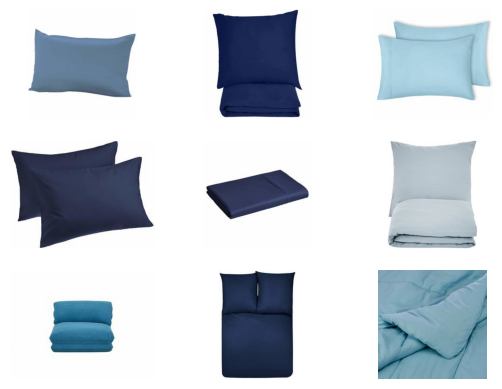

In [62]:
image_search.search("blue pillow")

Działa całkiem dobrze, ale czas przygotowania i potrzeba posiadania bazy jest problematyczny

## Zadanie dodatkowe (3 punkty)

Zapoznaj się z algorytmem [Condensed Nearest Neighbors](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm#Condensed_Nearest_Neighbor_for_data_reduction) . Jest to algorytm typu **training set reduction**, który zmniejsza rozmiar zbioru treningowego do klasyfikacji, usuwając z niego "trywialne" próbki. Idea jest tutaj taka, że znaczenie mają zasadniczo tylko przykłady blisko granicy decyzyjnej, a te daleko od niej są oczywiste i można by tam ograniczyć liczbę próbek, przyspieszając algorytmy najbliższych sąsiadów.

Zaimplementuj algorytm Condensed Nearest Neighbors w postaci klasy kompatybilnej ze Scikit-learn, z metodami `.fit()` oraz `.transform()`. Wejściem powinny być macierz X oraz wektor y, a wyjściem zredukowane macierze, ograniczone tylko do interesujących próbek. Niestety ten algorytm jest czuły na kolejność przetwarzania próbek, dlatego ma element losowy - zaimplementuj argument `random_state` w konstruktorze i go użyj do przemieszania losowo zbioru (mogą się przydać generatory losowe z Numpy'a). Dodatkowo konstruktor powinien przyjmować argument `metric` (analogicznie do `KNeighborsClassifier`) i wykorzystywać daną metrykę jako sposób pomiaru odległości.

Przetestuj algorytm na obu zbiorach używanych w tym laboratorium:
1. Sprawdź, o ile próbek udało się zredukować zbiory treningowe.
3. Porównaj szybkość treningu, szybkość predykcji oraz jakość wyników. Zmierz też czas wykonywania samego algorytmu Condensed Nearest Neighbors.
4. Skomentuj, czy twoim zdaniem warto korzystać z takiego rozwiązania.

Przydatne źródła:
- [dykusja na DataScience Stack Exchange](https://datascience.stackexchange.com/questions/47097/proper-understanding-of-condensed-nearest-neighbor)
- [prezentacja University of Leicester o kNN i CNN](http://www.math.le.ac.uk/people/ag153/homepage/KNN/OliverKNN_Presentation.pdf)

Dla zainteresowanych polecam artykuły naukowe:

Hart, Peter. *"The condensed nearest neighbor rule (corresp.)."* IEEE transactions on information theory 14.3 (1968): 515-516. [link](https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=7c3771fd6829630cf450af853df728ecd8da4ab2)

Angiulli, Fabrizio. *"Fast condensed nearest neighbor rule."* Proceedings of the 22nd international conference on Machine learning. 2005. [link](https://icml.cc/Conferences/2005/proceedings/papers/004_Fast_Angiulli.pdf)
